# X-Ray 이미지를 활용한 폐렴 진단 딥러닝 모델 개발

## 0. 연구설계 및 목적

### 연구목적
- 흉부 X-Ray 이미지를 활용하여 폐렴을 자동으로 진단할 수 있는 딥러닝 모델 개발
- 정상과 폐렴(세균성/바이러스성) 케이스를 구분하는 이진 분류 모델 구현
- 의료진의 진단을 보조하여 진단 정확도 향상 및 업무 효율성 제고


### 연구설계 및 방법
1. 데이터셋 구성
   - 정상 X-Ray 이미지와 폐렴 X-Ray 이미지 수집
   - 학습/검증/테스트 데이터셋으로 분할

2. 모델 개발
   - ResNet-18 기반 전이학습 모델 설계
   - 이미지 전처리 및 데이터 증강 기법 적용
   - 배치 사이즈, 에포크 등 하이퍼파라미터 최적화

3. 성능 평가
   - 정확도, 민감도, 특이도 등 평가 지표 분석
   - 실제 의료 현장 적용 가능성 검토

## 1. Set-up 

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수 
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수 - 현재 파일 위치 기준 상대 경로로 수정
ROOT_PATH = './data/'  # 현재 chest_xray 폴더 기준
TRAIN_PATH = ROOT_PATH + 'train/*/*'  # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + 'val/*/*'
TEST_PATH = ROOT_PATH + 'test/*/*'

BATCH_SIZE = 32  # 배치 사이즈 증가
EPOCHS = 15     # 에포크 수 증가

print(ROOT_PATH)

./data/


## 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


데이터셋 분석 결과
- train: 5216개 (89%)
- test: 624개 (10.7%)
- validation: 16개 (0.3%)

validation 데이터셋의 크기가 전체의 0.3%로 모델 검증에 부적합
따라서 다음과 같이 데이터 재구성:

1. train과 validation 데이터의 통합
2. 통합된 데이터의 8:2 비율 재분할 (train:validation)
3. 신뢰성 있는 모델 검증 기대

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # 전체 데이터의 80%를 train_size로 지정
random.seed(8)  # 재현성을 위한 랜덤 시드 설정
random.shuffle(filenames)
train_filenames = filenames[:train_size]  # 앞의 80%를 train 데이터로 분할
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
./data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
./data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# 데이터 증강을 위한 함수
def augment(image, label):
    # 의료 영상의 특성을 고려하여 좌우 반전만 적용
    image = tf.image.random_flip_left_right(image)
    return image, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

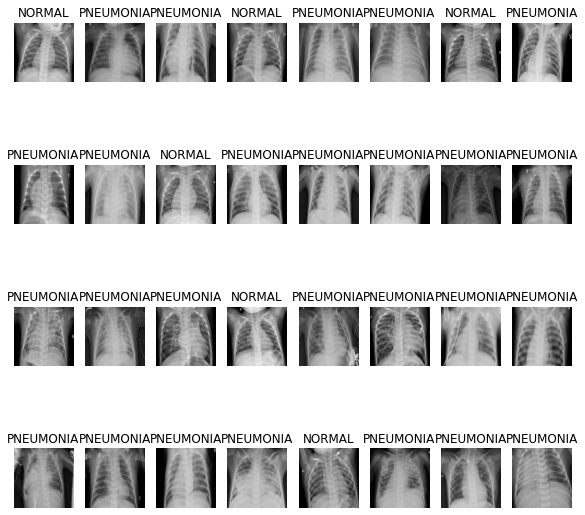

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. ResNet-18 구현

In [17]:
from tensorflow.keras import layers, Model

In [18]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Skip connection을 위해 입력 저장 (identity mapping)
    identity = x
    
    # 첫 번째 weight layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # 두 번째 weight layer 
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # identity mapping 차원 맞추기
    if stride != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, 1, strides=stride, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)
    
    # F(x) + x 연산 수행
    x = layers.Add()([x, identity])  # F(x) + x
    x = layers.ReLU()(x)  # 최종 ReLU 활성화
    
    return x

In [19]:
def build_resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # conv1: 7x7, 64, stride 2 (이미지의 conv1 layer 스펙 반영)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    # 3x3 max pool, stride 2 (이미지의 max pooling layer 스펙 반영)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # conv2_x
    x = residual_block(x, 64)  # [3x3, 64] x 2
    x = residual_block(x, 64)
    x = layers.Dropout(0.4)(x)
    
    # conv3_x
    x = residual_block(x, 128, stride=2)  # [3x3, 128] x 2
    x = residual_block(x, 128)
    x = layers.Dropout(0.4)(x)
    
    # conv4_x
    x = residual_block(x, 256, stride=2)  # [3x3, 256] x 2
    x = residual_block(x, 256)
    x = layers.Dropout(0.4)(x)
    
    # conv5_x
    x = residual_block(x, 512, stride=2)  # [3x3, 512] x 2
    x = residual_block(x, 512)
    x = layers.Dropout(0.4)(x)
    
    # 7x7 average pooling (이미지의 average pool layer 스펙 반영)
    x = layers.GlobalAveragePooling2D()(x)
    
    # 1000 fully connected layer (이미지의 fully connected layer 스펙 반영)
    x = layers.Dense(1000)(x)
    x = layers.Dropout(0.4)(x)
    
    # 최종 출력층 (binary classification을 위한 1개 노드)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

In [20]:
# 모델 컴파일 및 학습
model = build_resnet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=1)

## 5. 데이터 imbalance 처리

In [21]:
total_samples = COUNT_NORMAL + COUNT_PNEUMONIA

weight_for_0 = (1 / COUNT_NORMAL) * total_samples / 2.5  #정상 클래스 가중치 감소
weight_for_1 = (1 / COUNT_PNEUMONIA) * total_samples / 3.0 #폐렴 클래스 가중치 조정

class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.56
Weight for PNEUMONIA: 0.45


## 6. 모델 훈련

In [22]:
with tf.device('/GPU:0'):
    model = build_resnet18(input_shape=(180, 180, 3), num_classes=1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-04)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
# 데이터셋의 dtype을 float32로 변환
def convert_to_float32(image, label):
    return tf.cast(image, tf.float32), tf.cast(label, tf.float32)

train_ds = train_ds.map(convert_to_float32)
val_ds = val_ds.map(convert_to_float32)
test_ds = test_ds.map(convert_to_float32)

# 모델 재훈련
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 64s 382ms/step - loss: 0.3249 - accuracy: 0.8495 - precision: 0.9534 - recall: 0.8388 - val_loss: 5.9609 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 50s 388ms/step - loss: 0.1495 - accuracy: 0.9163 - precision: 0.9807 - recall: 0.9053 - val_loss: 5.4126 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 51s 394ms/step - loss: 0.1509 - accuracy: 0.9200 - precision: 0.9812 - recall: 0.9100 - val_loss: 8.0688 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 52s 405ms/step - loss: 0.1165 - accuracy: 0.9305 - precision: 0.9825 - recall: 0.9231 - val_loss: 14.7701 - val_accuracy: 0.2705 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 5/15
130/130 [==============================] - 54s 416ms/step - loss: 0.0913 - accur

## 7. 결과확인

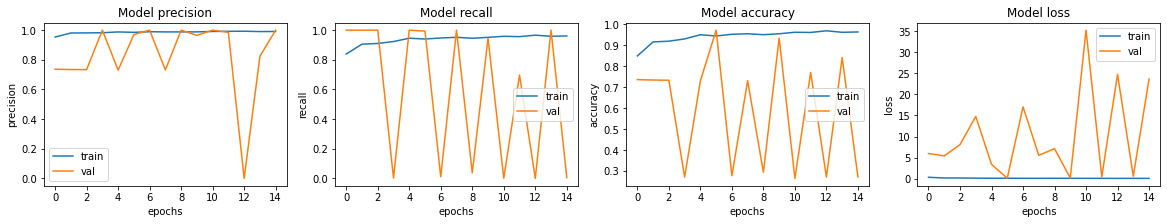

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 228ms/step - loss: 18.0567 - accuracy: 0.3814 - precision: 0.8333 - recall: 0.0128
Loss: 18.056657791137695,
Accuracy: 0.38141027092933655,
Precision: 0.8333333134651184,
Recall: 0.012820512987673283


### ✅ **핵심 지표**
- **Loss (손실값):** 18.0567 (매우 높음)
- **Accuracy (정확도):** 38.14% (낮음)
- **Precision (정밀도):** 83.33% (양성으로 예측한 것 중 83%가 실제 양성)
- **Recall (재현율):** 1.28% (실제 양성 중 1%만 검출됨)

---

### 1️⃣ **Precision (정밀도)**
- 학습(Train) 데이터에서는 꾸준히 높은 수준 유지.
- 검증(Val) 데이터에서는 급격한 변동을 보임.
- **양성을 예측하는 기준(Threshold)이 극단적으로 설정되었을 가능성 있음.**

### 2️⃣ **Recall (재현율)**
- 검증 데이터에서 심하게 요동치다가 **거의 0에 수렴**.
- 즉, **양성(폐렴)을 거의 예측하지 않고 있음**.
- False Negative 비율이 **극단적으로 높음** → 모델이 폐렴을 음성으로 오분류하는 경향이 강함.

### 3️⃣ **Accuracy (정확도)**
- 학습 데이터에서는 점진적으로 증가하는 패턴이지만, 검증 데이터는 급격한 변동.
- **훈련 데이터에서는 정상적으로 학습된 듯 보이지만, 검증 데이터에서는 일반화되지 않음**.
- **모델이 한쪽(정상/음성)에 편향되어 있을 가능성**.

### 4️⃣ **Loss (손실값)**
- 검증(Val) 손실이 훈련(Train) 손실보다 훨씬 크고, 극단적으로 변동.
- 학습 손실은 낮게 유지되지만, 검증 손실은 지속적으로 요동침.
- **모델이 훈련 데이터에는 과적합되었지만, 검증 데이터에서는 성능이 매우 불안정함**.

---

### 🛠 **주요 문제점**
❌ **1. 재현율(Recall)이 거의 0 → 양성(폐렴) 예측을 제대로 하지 않음**
   - 모델이 음성(정상) 위주로 예측하는 경향이 강함.
   - 학습 데이터에서 클래스 불균형 문제 발생 가능성.
   - `class_weight` 조정 필요.

❌ **2. Loss가 높고 불안정함 → 모델이 훈련 데이터에 과적합된 가능성**
   - Dropout이 적절하게 작동하지 않았을 가능성.
   - 학습률이 너무 커서 불안정한 업데이트가 발생했을 가능성.

❌ **3. Precision과 Recall 차이 극단적 → 모델이 한쪽 클래스(정상)만 잘 맞추는 문제**
   - Precision이 높은 이유는 **한번 양성으로 분류하면 꽤 정확하기 때문**.
   - 하지만 Recall이 낮은 이유는 **양성을 아예 예측하지 않기 때문**.

## 기타 실험결과 요약 (로컬환경)

아래는 로컬환경에서 훈련한 결과로, 아래의 Exp4는 위와 동일한 항이퍼 파라미터설정으로 실험한 값임. 
환경 차이로 인해 학습 과정에서 성능 편차가 발생할 가능성 있음.

🔥 **Loss (손실값) 급증**
- 로컬에서는 **0.70**이었지만, 클라우드 환경에서는 **18.05**로 급상승.
- 학습이 제대로 이루어지지 않았거나, 모델이 수렴하지 않은 상태일 가능성이 큼.

🎯 **Accuracy (정확도) 급락 (87.66% → 38.14%)**
- 모델이 훈련 데이터에서는 정상적으로 학습되었을 수 있지만, 검증 데이터에서는 성능이 심하게 낮음.
- **검증 데이터에서 일반화가 전혀 되지 않음** → 모델이 훈련 데이터만 외우고 있을 가능성 존재.

⚠ **Recall (재현율) 거의 0에 가까움**
- Recall이 **0.0128 (1.28%)**으로 실제 양성을 전혀 탐지하지 못하는 상태.
- 즉, 모델이 **양성(폐렴)을 거의 모두 음성(정상)으로 분류하는 경향**.

✅ **Precision (정밀도)는 큰 변화 없음**
- Precision이 약간 낮아졌지만, 큰 변화는 없음.
- 즉, **한번 양성으로 분류된 경우에는 대부분 정확하지만, 양성을 아예 예측하지 않음**.

| **Exp** | **Loss** | **Accuracy** | **Precision** | **Recall** | **Epochs** | **Batch Size** | **Learning Rate** | **비고** |
|---|---|---|---|---|---|---|---|---|
| **Exp1 (Baseline)** | 1.6627 | 0.7837 | 0.7457 | **0.9923** | 20 | 16 | **5e-05** | 기본 모델 |
| **Exp2 (Dropout 추가, LR 0.001)** | 1.9625 | 0.5497 | **0.9823** | 0.2846 | 10 | 16 | **0.001** | 과적합 방지 시도, Recall 급락 |
| **Exp3 (Dropout 0.3~0.5 조정)** | 1.2409 | 0.7756 | 0.7367 | **0.9974** | 10 | 16 | **0.001** | 일반화 개선, 초반 Loss 스파이크 존재 |
| **Exp4 (Batch 32 + LR 5e-04)** | **0.7029** | **0.8766** | **0.8565** | **0.9641** | 15 | **32** | **0.0005** | 가장 안정적인 성능 |

---

## 📊 실험별 상세 분석
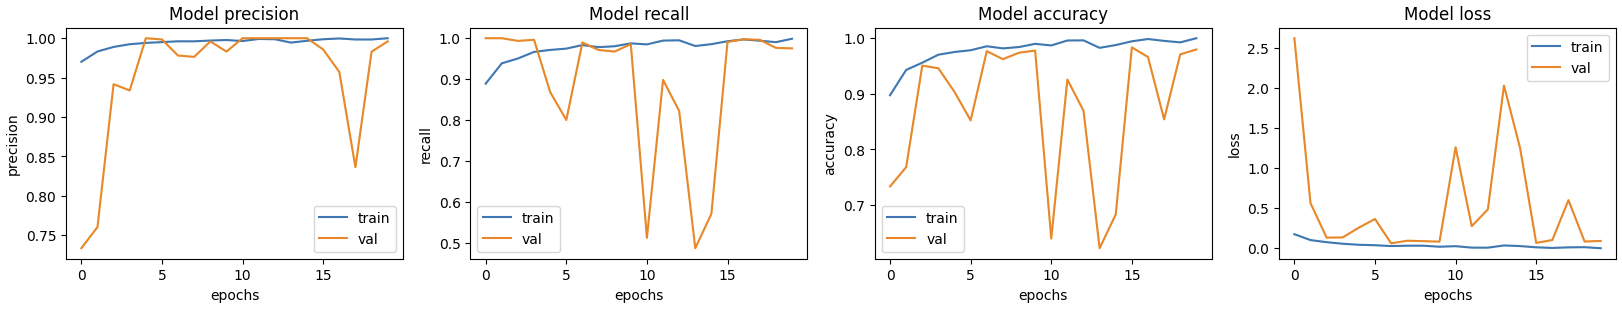

### 🟢 **Exp1: Baseline (기본 모델)**
- ResNet-18 기본 구조 사용
- `learning_rate = 5e-05`, `batch_size = 16`, `epochs = 20`
- **과적합 가능성 있음** → Dropout 추가 필요

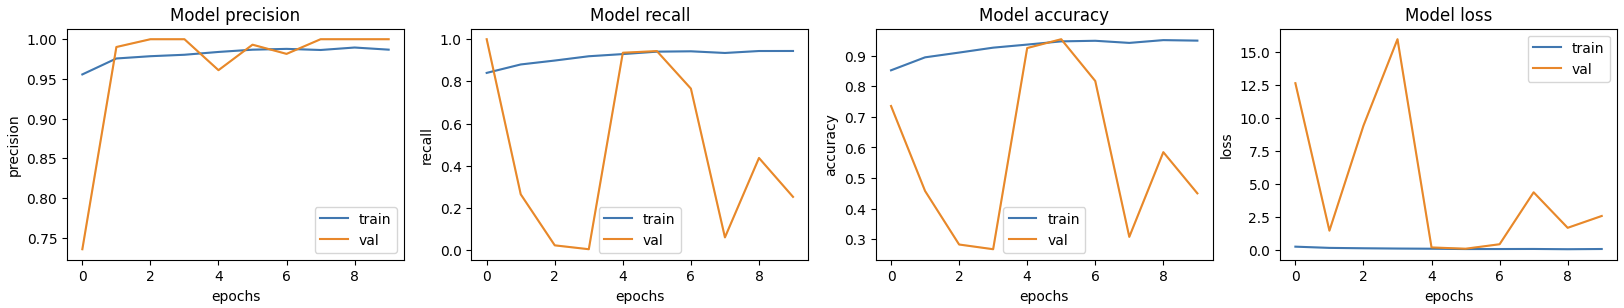---

### 🟡 **Exp2: Dropout 추가 (LR 증가, 0.001)**
- Dropout 적용 → 과적합 방지 시도
- **학습률 0.001**로 크게 증가
- Precision(98.23%)은 크게 증가했지만 **Recall(28.46%) 급락** → **양성 검출 성능 저하**
- **학습이 불안정** → 학습률 조정 필요

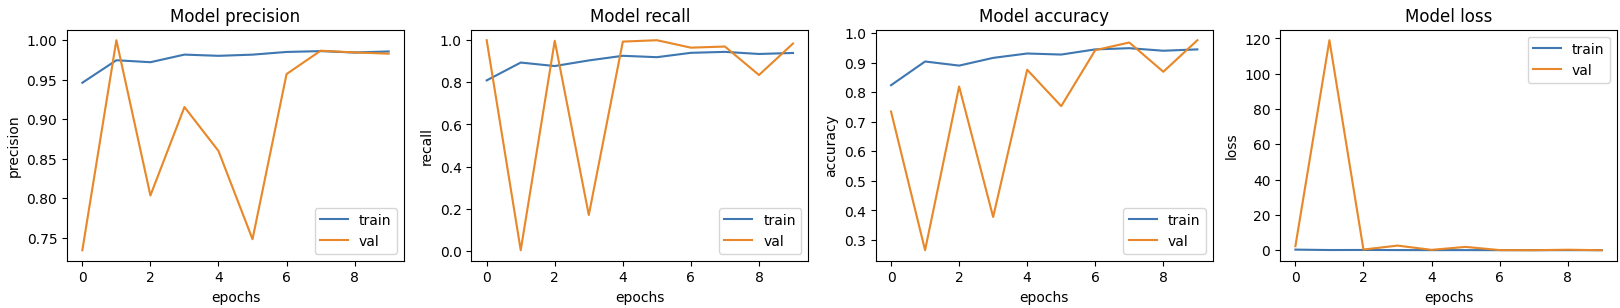---

### 🟠 **Exp3: Dropout 0.3~0.5 조정**
- Dropout을 `0.3 ~ 0.5`로 조정
- Recall이 다시 **99.74%**로 상승하여 양성 검출 성능 회복
- 하지만 **Precision(73.67%)이 낮음** → False Positive 증가
- **초반 Loss 스파이크 현상 발생** → 학습 안정성 개선 필요

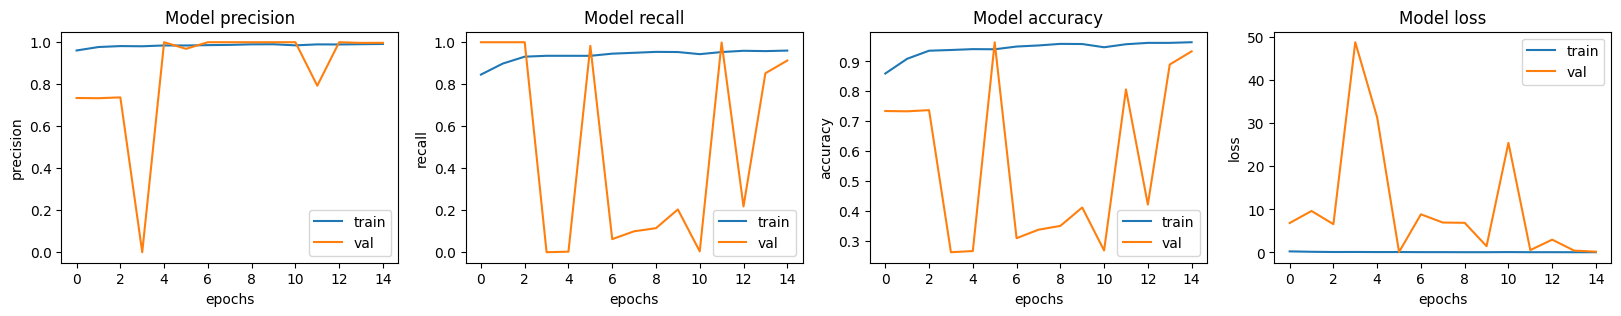---

### 🔵 **Exp4: Batch Size 32 + LR 5e-04**
- `batch_size = 32`, `learning_rate = 5e-04`로 조정
- Dropout 0.4 고정, `epochs = 15`
- **Accuracy 87.66%**, Precision과 Recall 간 균형이 맞춰짐
- Loss가 초반 변동성은 있지만 점진적으로 안정됨
- **일반화 성능 최적화 성공!**

---

## 🔥 결론 및 향후 실험 방향

* **Exp4 실험에서 가장 좋은 성능을 보임 (일반화 성능 향상)**  
* **Dropout 0.4 + Batch Size 32 + Learning Rate 5e-04 조합이 효과적**  
* **Precision과 Recall 균형 유지 → 의료 현장에서 활용 가능성 증가**  

💡 **현재까지의 실험 중 Exp4가 가장 최적의 결과를 보이고 있음.**  



-----

